# PCA Tutorial

This very simple tutorial shows you how to perform PCA with [GRG](https://grgl.readthedocs.io/en/stable/concepts.html) files. In this example, we're going to first simulate some data with populations structure, and then compute the principal components and show that they reflect that structure.

**What you'll need:**

* Python dependencies "stdpopsim", "msprime", "grapp", "pandas", "seaborn": `pip install stdpopsim msprime grapp pandas seaborn`

## Simulate Data

We're going to use [stdpopsim](https://popsim-consortium.github.io/stdpopsim-docs/stable/index.html) and [msprime](https://tskit.dev/msprime/docs/stable/intro.html) to simulate the data we need. The result of that simulation will be simulated Ancestral Recombination Graphs (ARGs) in [tskit](https://tskit.dev/tskit/docs/stable/introduction.html) format. Given such an ARG, we have two options for converting it to GRG:
* We can convert the ARG directly to a GRG by graph transformations. This is extremely fast, but only works on simulated data. We sometimes refer to this as the "true ARG" and the "true GRG", since they did not need to be inferred from data.
* A more realistic approach is to build a GRG from tabular data, like `.vcf.gz` or [IGD](https://picovcf.readthedocs.io/en/latest/igd_overview.html). For simulated data, the fastest way to do this is `true ARG -> true GRG -> IGD`. We then generate an "constructed GRG" from the IGD file.

We show both of these approaches below.

First, we need to actually simulate the data. This takes a couple of minutes to run on my laptop.

In [1]:
import stdpopsim

# We will simulate 400 diploid individuals in total, equally spread across populations.
individuals = 400
i_per_pop = individuals // 4

# Setup the options for stdpopsim
species = stdpopsim.get_species("HomSap")
samples = {"CEU": i_per_pop, "CHB": i_per_pop, "YRI": i_per_pop, "JPT": i_per_pop}
contig = species.get_contig("chr22", genetic_map="HapMapII_GRCh38")
engine = stdpopsim.get_engine("msprime")
model = species.get_demographic_model("OutOfAfrica_4J17")

# Simulate the data, which returns an ARG "ts" and then we also save that ARG to disk.
ts = engine.simulate(model, contig, samples)
ts.dump(f"stdpop.ooa4.chr22.trees")

/home/ddehaas/Py3Env/lib/python3.10/site-packages/stdpopsim/engines.py:111: UserWarning: The demographic model has mutation rate 1.44e-08, but this simulation used the contig's mutation rate 1.29e-08. Diversity levels may be different than expected for this species. For details see documentation at https://popsim-consortium.github.io/stdpopsim-docs/stable/tutorial.html
  warnings.warn(


In [2]:
list(ts.populations())

[Population(id=0, metadata={'description': '1000 Genomes YRI (Yoruba)', 'id': 'YRI', 'name': 'YRI', 'sampling_time': 0}),
 Population(id=1, metadata={'description': '1000 Genomes CEU (Utah Residents (CEPH) with Northern and Western European Ancestry)', 'id': 'CEU', 'name': 'CEU', 'sampling_time': 0}),
 Population(id=2, metadata={'description': '1000 Genomes CHB (Han Chinese in Beijing, China)', 'id': 'CHB', 'name': 'CHB', 'sampling_time': 0}),
 Population(id=3, metadata={'description': '1000 Genomes JPT (Japanese in Tokyo, Japan)', 'id': 'JPT', 'name': 'JPT', 'sampling_time': 0})]

Now lets convert from the tree-sequence format ("ts") to GRG. This should be extremely fast.

In [3]:
import pygrgl

true_grg = pygrgl.grg_from_trees("stdpop.ooa4.chr22.trees")

One of the nice time-saving features of converting a simulated ARG to a GRG is that we copy over two useful pieces of metadata: the times associated with Mutations, and the Population labels associated with samples. Below, we dump the population information (we'll want it later) and save it to a separate file as well (also for later).

In [4]:
import json
import pandas

# Get the population labels in a form we want.
pops = []
for pop_id, pop_metadata in enumerate(true_grg.get_populations()):
    # If the tree-sequence stored the population as JSON, try to parse it.
    try:
        jpop = json.loads(pop_metadata)
        pops.append(jpop["name"])
    except:
        pops.append(pop_metadata)

# GRG stores population labels per sample ndoe (haplotype), instead of per-individual. So we just want to save
# tab-separated file, in sample-node order, of the labels.
sample_pops = pandas.DataFrame({
    "Sample": range(true_grg.num_samples),
    "Population": [pops[true_grg.get_population_id(s)] for s in range(true_grg.num_samples)]
})
sample_pops.to_csv("pop_mapping.tsv", sep="\t", index=False)
sample_pops

,Sample,Population
0,0,YRI
1,1,YRI
2,2,YRI
3,3,YRI
4,4,YRI
...,...,...
795,795,JPT
796,796,JPT
797,797,JPT
798,798,JPT


We can use this GRG directly if we want, but instead we're going to export it to IGD so that we can construct a GRG from tabular data, in a more realistic way. This export process can be a bit slow (takes about 30-60 seconds on my laptop), because it is taking a very concise data structure (GRG) and creating a much less concise sparse matrix format (IGD) from it.

In [5]:
from grapp.util.igd import export_igd

export_igd(
    true_grg,
    "stdpop.ooa4.chr22.igd",
    jobs=4,
    verbose=True,
)

Using temporary directory /tmp/tmp1zgc_nhy.
Splitting GRG into 8 parts..
Converting GRG parts to IGD files...
Merging 8 parts into single IGD stdpop.ooa4.chr22.igd...


Finally, lets create a GRG from the IGD. Again, if you had real data you would just have a `.vcf.gz` or IGD file already, and this would be the first step. The above was just to illustrate the various ways that simulated data can be used. The grg construction below takes about 10 seconds on my laptop.

In [6]:
%%bash

# Now we're using that population map file that we exported above! This tells GRG how to label each sample
# with it's population. The format of the argument is "filename:sample_field:pop_field", where the two field
# names are the names we gave the columns in our tab-separated file.
# The "sample" column must be string individual identifiers if the GRG has identifiers for individuals, otherwise
# it must be the sample index (i.e., the order of that sample in all 2N samples).
grg construct --population-ids "pop_mapping.tsv:Sample:Population" -j 4 stdpop.ooa4.chr22.igd -o stdpop.ooa4.chr22.grg

Processing input file in 100 parts.
Auto-calculating number of trees per part.
Converting segments of input data to graphs
100%|██████████| 100/100 [00:10<00:00,  9.36it/s]
Merging...


=== GRG Statistics ===
Nodes: 296524
Edges: 2178293
Samples: 800
Mutations: 359119
Ploidy: 2
Phased: true
Populations: 4
Range of mutations: 15287934 - 50818401
Specified range: 0 - 359628
Wrote simplified GRG with:
  Nodes: 296524
  Edges: 2178293
Wrote GRG to stdpop.ooa4.chr22.grg


## Performing PCA

Now that we have a GRG (well, two actually), lets load it, perform PCA, and show that the results are identical between the two GRGs (it is the same data, just converted into graphs in two different ways).

In [7]:
grg = pygrgl.load_immutable_grg("stdpop.ooa4.chr22.grg")
print(f"Populations: {grg.get_populations()}")
print(f"Individuals: {grg.num_individuals}")
print(f"Mutations (Variants): {grg.num_mutations}")

Populations: ['YRI', 'CEU', 'CHB', 'JPT']
Individuals: 400
Mutations (Variants): 359119


In [8]:
from grapp.linalg import PCs

# First 2 PCs on the constructed GRG. This is very fast! A few seconds on my laptop.
pca_df = PCs(grg, 2, unitvar=False)
pca_df

,PC1,PC2
Individual,,
0,194.193031,-20.152374
1,204.976810,-14.595821
2,203.829988,-19.090026
3,195.460814,-28.349895
4,199.813934,-14.681065
...,...,...
395,-77.386700,-65.259156
396,-83.253270,-64.976000
397,-81.988488,-63.991201


In [9]:
# First 2 PCs on the "true" GRG (converted from ARG). This is a bit slower - about 20-30 seconds on my laptop.
# This highlights something interesting: the constructed GRG is created for speed and compression, and is the one that 
# is used on real data. The "true" GRG still contains a lot of the coalescence structure from the ARG, which may be
# less performant for linear algebra.
true_pca_df = PCs(true_grg, 2, unitvar=False)
true_pca_df

,PC1,PC2
Individual,,
0,194.275947,-20.147350
1,205.092217,-14.601785
2,203.893973,-19.053393
3,195.542736,-28.301942
4,199.833256,-14.653547
...,...,...
395,-77.387497,-65.264807
396,-83.308376,-65.039118
397,-82.017372,-64.053615


Visual inspection of the dataframes above indicates that the two GRGs produce nearly identical PCA results. Now we'll plot all the individuals in the dataset, for both sets of PCs, where the X-axis is PC1 and the Y-axis is PC2. The colors of the dots correspond to the original population identifiers for the individuals, as defined by the original simulation we did.

Text(0.5, 1.0, 'PCA via "True" GRG')

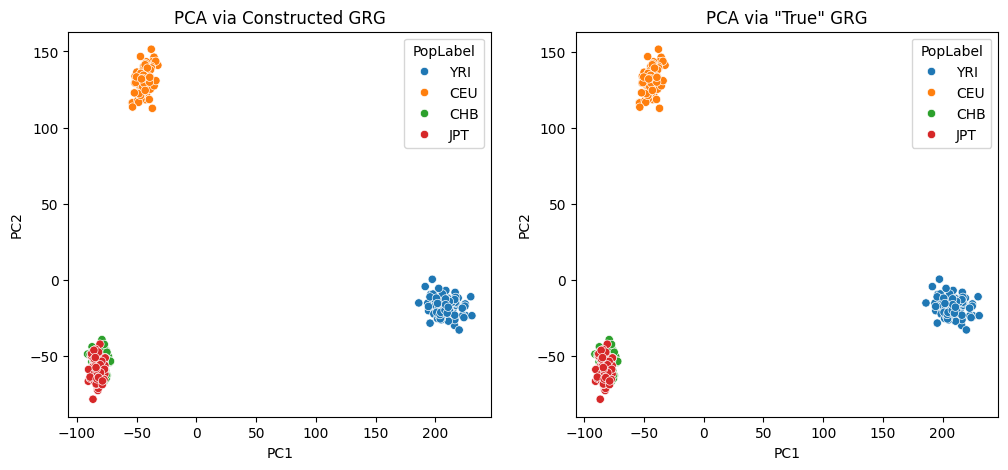

In [10]:
import matplotlib.pyplot as plt
import seaborn

# First, lets map each individual to population label and put that in a dataframe.
labels = grg.get_populations()
label_df = pandas.DataFrame({"PopLabel": [labels[grg.get_population_id(grg.ploidy * i)] for i in range(grg.num_individuals)]})

constructed_df = pandas.concat([pca_df, label_df], axis=1)
true_df = pandas.concat([true_pca_df, label_df], axis=1)

f, axs = plt.subplots(1, 2, figsize=(12, 5))
seaborn.scatterplot(data=constructed_df, x="PC1", y="PC2", hue="PopLabel", ax=axs[0])
axs[0].set_title("PCA via Constructed GRG")
seaborn.scatterplot(data=true_df, x="PC1", y="PC2", hue="PopLabel", ax=axs[1])
axs[1].set_title("PCA via \"True\" GRG")

Depending on some non-deterministic behavior in the underlying eigen solve, you may notice that slight numerical differences result in the plots above being identical, except for a rotation about one of the axes. The PCs are still equivalent in this case!

You can increase the number of PCs to compute somewhat arbitrarily, but we don't recommend computing them all: we're using an [iterative eigen decomposition algorithm via scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.eigs.html#scipy.sparse.linalg.eigs) and it will not perform well when asking for all eigen values/vectors.

You can also try the `use_pro_pca=True` options when calling `PCs()`, which will use the algorithm described in the paper [Scalable probabilistic PCA for large-scale genetic variation data](https://pubmed.ncbi.nlm.nih.gov/32469896/) by Agrawal, et. al.

## Related Topics

* See [LinearOperators](LinearOperators.html) for information on the [scipy](https://scipy.org/) linear algebra integration that underlies this PCA approach.
* Documentation links:
  * [grapp.linalg](https://grapp.readthedocs.io/en/latest/grapp.html#linear-algebra): Python APIs for Linear Algebra on GRG